## Create PyTorch dataset + dataloaders

Here we define a regular PyTorch dataset. Each item of the dataset is an image and corresponding annotations. Torchvision already provides a `CocoDetection` dataset, which we can use. We only add a feature extractor (`DetrFeatureExtractor`) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.

In [1]:
DATA_BASE = 'data/balloon/'

In [2]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["target"][0] # remove batch dimension

        return pixel_values, target

In [3]:
# Based on the class defined above, we create training and validation datasets.
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=f'{DATA_BASE}/train', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=f'{DATA_BASE}/val', feature_extractor=feature_extractor, train=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 61
Number of validation examples: 13


Image n°49


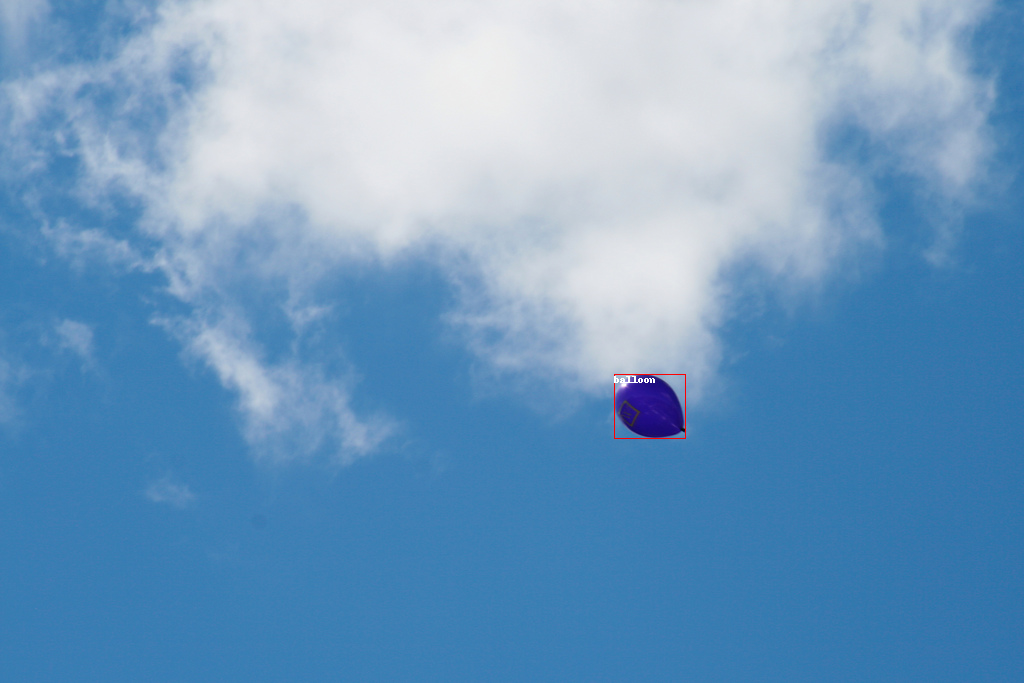

In [6]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{DATA_BASE}/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [7]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
t_it = iter(train_dataloader)
batch = next(t_it)

In [8]:
# batch = next(t_it)
# import matplotlib.pyplot as plt
# for i in range(0,4):
#     plt.imshow(batch['pixel_values'][i].permute(1,2,0))
#     plt.show()

In [10]:
import lib

In [19]:
from transformers import DetrConfig, DetrForObjectDetection
import transformers


<module 'transformers.models.detr.modeling_detr' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\transformers\\models\\detr\\modeling_detr.py'>

In [41]:
from importlib import reload
reload(lib)
reload(lib.DETR)

<module 'lib.DETR' from 'C:\\Users\\Sholto Douglas\\Desktop\\artificial_graphics\\lib\\DETR.py'>

In [42]:
from lib.DETR import DetrForObjectDetection
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

In [31]:
state_dict = model.state_dict()

In [32]:
state_dict

OrderedDict([('model.backbone.conv_encoder.model.conv1.weight',
              tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
                         -4.3034e-02, -7.0755e-02],
                        [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
                         -2.0912e-02, -3.8517e-02],
                        [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
                          6.2641e-02,  5.1977e-02],
                        ...,
                        [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
                         -7.6604e-02,  7.8453e-03],
                        [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
                         -3.3662e-02, -1.5709e-02],
                        [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
                          2.2439e-02,  1.7077e-03]],
              
                       [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02

In [34]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
         state_dict = model.state_dict()
         # Remove class weights
         del state_dict["class_labels_classifier.weight"]
         del state_dict["class_labels_classifier.bias"]
         # define new model with custom class classifier
         config = DetrConfig.from_pretrained("facebook/detr-resnet-50", num_labels=len(id2label))
         model = DetrForObjectDetection(config)
         model.load_state_dict(state_dict, strict=False)
         self.model = model

         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [38]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\ProgramData\Anaconda3\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [39]:
from pytorch_lightning import Trainer

trainer = Trainer(gpus=0, max_steps=300, gradient_clip_val=0.1)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.037   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\Sholto Douglas\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
C:\Users\Sholto Douglas\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

C:\Users\Sholto Douglas\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
